In [8]:
from os import remove
from os.path import join
from re import compile, search, findall
from numpy import (
    ndarray,
    array,
    ascontiguousarray,
    zeros,
    empty,
    any,
    diagonal,
    int64,
    float64,
    complex128,
)
from h5py import File
from typing import Tuple
from numpy.linalg import eigh, eigvalsh
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.cm as cm
import numpy as np
import h5py
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd


def gaussian(x, mu, sigma, area):
    normalization = area / (sigma * np.sqrt(2 * np.pi))
    return normalization * np.exp(-0.5 * ((x - mu) / sigma) ** 2)

def lorentzian(x, mu, gamma, area):
    
    return area / (np.pi) * (gamma) / ((x - mu)**2 + gamma**2)
def convolute_spectral_lines_l(energies, intensities, fwhm, resolution=1000):
    sigma = fwhm / (2 * np.sqrt(2 * np.log(2)))
    x_min, x_max = min(energies) - 5 * fwhm, max(energies) + 5 * fwhm
    x_values = np.linspace(x_min, x_max, resolution)
    conv_spectrum = np.zeros_like(x_values)

    for energy, intensity in zip(energies, intensities):
        area = intensity  # Assuming intensity is proportional to the desired area
        conv_spectrum += lorentzian(x_values, energy, sigma, area)

    return x_values, conv_spectrum

def convolute_spectral_lines_g(energies, intensities, fwhm, resolution=1000):
    sigma = fwhm / (2 * np.sqrt(2 * np.log(2)))
    x_min, x_max = min(energies) - 5 * fwhm, max(energies) + 5 * fwhm
    x_values = np.linspace(x_min, x_max, resolution)
    conv_spectrum = np.zeros_like(x_values)

    for energy, intensity in zip(energies, intensities):
        area = intensity  # Assuming intensity is proportional to the desired area
        conv_spectrum += gaussian(x_values, energy, sigma, area)

    return x_values, conv_spectrum
def relative_boltzmann_distribution(x, y, T):

    k = 3.166811563e-6  # Boltzmann constant in a.u./K
    delta_E = y - x   # Energy difference

    return np.exp(-delta_E / (k * T))


def _get_orca_so_blocks_size(
    path: str, orca_file: str
) -> tuple[int, int, int, int]:
    orca_file_path = join(path, orca_file)
    
    with open(orca_file_path, "r") as file:
        content = file.read()

    so_dim=14

    num_blocks = so_dim // 6

    if so_dim % 6 != 0:
        num_blocks += 1

    block_size = ((so_dim + 1) * num_blocks) + 1
    num_of_whole_blocks = so_dim // 6
    remaining_columns = so_dim % 6

    return so_dim, block_size, num_of_whole_blocks, remaining_columns

In [6]:
import slothpy as slt
from slothpy._general_utilities._constants import B_AU_T
import numpy as np
from threadpoolctl import threadpool_limits
import os
os.remove('Nd_lumi.slt')
Yb=slt.hamiltonian_from_orca('Yb_bpdo_casscf_nevpt2_dipmom2_x2c.out','Nd_lumi','test',True, True, False)
# Yb = slt.slt_file("Nd_lumi.slt")
# Yb["test"].s[:]
#print(Yb)
with threadpool_limits(4):
    from scipy.spatial.transform import Rotation
    magnetic_field = - np.asarray([0.01,0.01,0.01]) / B_AU_T
    M = Yb["test"].magnetic_dipole_momentum_matrices("xyz").eval()
    ham_zeeman = M[0] * magnetic_field[0] + M[1] * magnetic_field[1] + M[2] * magnetic_field[2]
    # magnetic_field[:,np.newaxis, np.newaxis] * M
    energies = Yb["test"].states_energies_au().eval()
    for i in range(ham_zeeman.shape[0]):
        ham_zeeman[i,i] += energies[i] #tu musi byc rzeczywiste, poprawic mnozenie l i s, -07=0
    energies2, eigenvectors = np.linalg.eigh(ham_zeeman)
    dipole_momenta = Yb["test"].electric_dipole_momentum_matrices("xyz").eval()
    # print(np.diagonal(dipole_momenta[0]))
    transformed_dip_mom = eigenvectors.conj().T[np.newaxis, :, :] @ dipole_momenta @ eigenvectors #rzeczywiste, czemu taka duza energia
    #To chyba działało tez bez tego newaxis ale trzeba sprawdzic

    #print(np.diag(transformed_dip_mom[0]))
    print(1e7/(energies*219474.6))
    #print(energies)

[           inf 2.50487215e+13 9.43405866e+03 9.43405864e+03
 6.68567866e+03 6.68567865e+03 3.46525316e+03 3.46525315e+03
 2.67695215e+03 2.67695214e+03 2.20715502e+03 2.20715502e+03
 1.83302157e+03 1.83302157e+03]


/tmp/ipykernel_3044705/2535103938.py:27: RuntimeWarning: divide by zero encountered in divide
  print(1e7/(energies*219474.6))


In [9]:

emissive_levels=[8]    
    





F = [emissive_levels]
temperatures = np.linspace(10,10, 1)
fwhm = 50
normalize = 1
resolution = 20000
sum_spectra = np.zeros((resolution, ), dtype=np.float64)


fig, axs = plt.subplots(1, 1, figsize=(12, 9))


dipmom = transformed_dip_mom[:]

  
for index, F_emissive in enumerate(F):
    for T in temperatures:    
        intensities = np.zeros((len(F_emissive),F[0][0]), dtype = np.float64)
        emission_energies_cm = np.zeros((len(F_emissive), F[0][0]), dtype = np.float64)
        for l, level in enumerate(F_emissive):
            for i in range(F[0][0]):
                for k in range(3):
                    intensities[l,i] += relative_boltzmann_distribution(energies[F_emissive[0]], energies[level], T) * 2/3 * np.abs(dipmom[k, i, level])**2 * (energies[level] - energies[i])
                    emission_energies_cm[l,i] = ((energies[level] - energies[i]) * 219474.6)
        intensities = intensities.flatten()
        emission_energies_cm = emission_energies_cm.flatten()
        intensities = intensities/max(intensities)
        
        emission_energies_nm = 1e7/emission_energies_cm
        energy_x_cm, spectrum = convolute_spectral_lines_l(emission_energies_cm, intensities, fwhm, resolution)
        spectrum = spectrum/max(spectrum) 
        sum_spectra += spectrum
        energy_x_nm = 1e7/energy_x_cm
      
        
        
    
        
    
axs.vlines(x=emission_energies_nm, ymin=0, ymax=intensities, label="T")
axs.plot(energy_x_nm, spectrum, label=f'{T}')


print(emission_energies_nm)
print(intensities)       


axs.set_xlabel('Energy')
axs.set_ylabel('Intensity')
axs.set_title('Spectral Lines')
axs.set_xlim([800, 1100])
axs.set_ylim([0,normalize])

#df = pd.read_csv('Yb_bpdo_exp.csv',sep=';')



#axs.plot(df[df.columns[0]], df[df.columns[1]]/df[df.columns[1]].max(), linewidth=1.0)
axs.vlines(x=emission_energies_nm, ymin=0, ymax=intensities, label="T")
axs.plot(energy_x_nm, spectrum, label=f'{T}')

#df=pd.DataFrame({'x':energy_x_nm,'sp':spectrum})
#df2=pd.DataFrame({'int':intensities,'en':emission_energies_nm})
#df.to_csv('Yb_bezopt_casscf_opt_pt2_spectrum')
#df2.to_csv('Yb_bezopt_casscf_opt_pt2_int')
#energies

[ 2676.95214611  2676.9521464   3737.47602219  3737.47602498
  4464.57042658  4464.57042897 11767.48062525 11767.48065289]
[1.         0.16268932 0.59500252 0.2686833  0.40344679 0.02576132
 0.29642316 0.01759165]


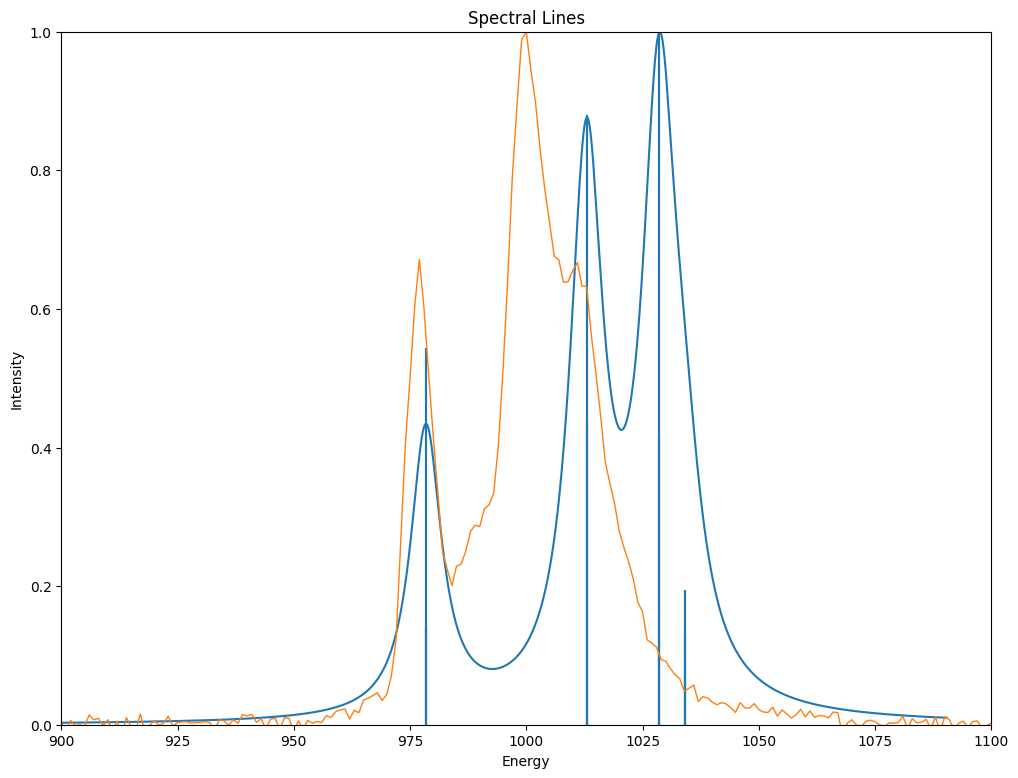

In [8]:
EMISSION('.','Yb_bpdo_casscf_nevpt2_dipmom_opt.out','.','Yb_npt2','4',True,[8,9,10,11,12,13],'.','Yb_bpdo_exp.csv',';')